In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import kaggle
import os
import numpy as np
import glob
import cv2
import random
import time

# Dataset

*https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge*

This dataset is approximately 5GB in size, so downloading it may take some time. Note that you don't need the entire dataset to get started. It consists of five folders, and downloading just one of them will be sufficient for your needs.

In [2]:
# Define the Kaggle dataset URL and download path
dataset_url = 'kumaresanmanickavelu/lyft-udacity-challenge'
download_path = './road_dataset'

# Check if the dataset is already downloaded
if os.path.isdir(download_path) and any(os.scandir(download_path)):
    print(f'Dataset already exists in {download_path}')
else:
    print(f'Downloading dataset from Kaggle: {dataset_url}')
    kaggle.api.dataset_download_files(dataset_url, path=download_path, unzip=True)
    print(f'Dataset downloaded and extracted to {download_path}')

Dataset already exists in ./road_dataset


In [3]:
def display_images(data_folder, num_to_display, shuffle=False):
    if num_to_display < 2 or num_to_display % 2 != 0:
        raise ValueError("num_to_display must be an even number and at least 2.")
       
    image_paths = glob.glob(f'./road_dataset/{data_folder}/{data_folder}/CameraRGB/*.png')  # returns list of file path
    mask_paths =  glob.glob(f'./road_dataset/{data_folder}/{data_folder}/CameraSeg/*.png')

    # Pick randomly images
    if shuffle:
        selected_indices = random.sample(range(len(image_paths)), num_to_display)
        image_paths = [image_paths[i] for i in selected_indices]
        mask_paths = [mask_paths[i] for i in selected_indices]
    else:
        image_paths = image_paths[:num_to_display]
        mask_paths = mask_paths[:num_to_display]

    # Convert images to arrays
    image_arrs = [None] * num_to_display
    mask_arrs = [None] * num_to_display
    for i in range(num_to_display):
        image_arrs[i] = cv2.imread(image_paths[i])
        mask_arrs[i] = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # if not IMREAD_GRAYSCALE, images will be black

    # Visualize a pair of 2 images, 2 masks in each row
    fig, axes = plt.subplots(num_to_display//2, 4, figsize=(12, 12))
    axes = axes.flatten()
    for i in range(num_to_display):
        axes[2*i].imshow(image_arrs[i])
        axes[2*i + 1].imshow(mask_arrs[i], cmap='gray')
        axes[2*i].axis('off')
        axes[2*i + 1].axis('off')
        
    plt.tight_layout()
    plt.show()

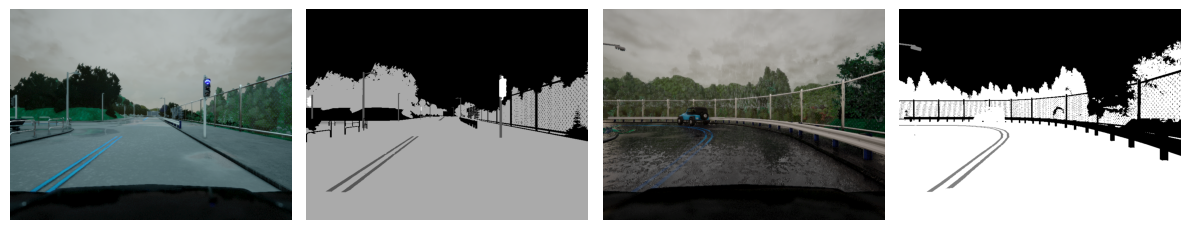

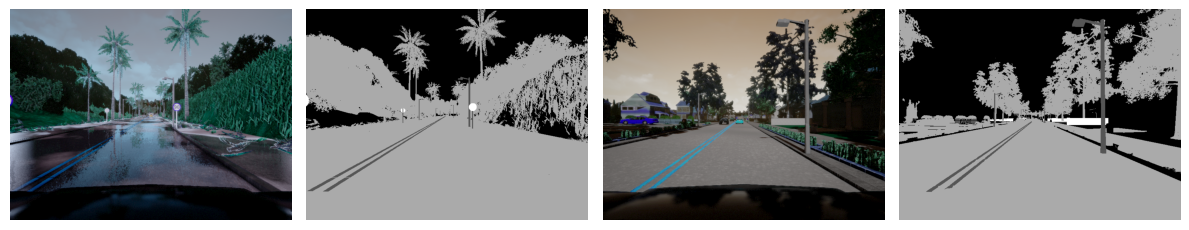

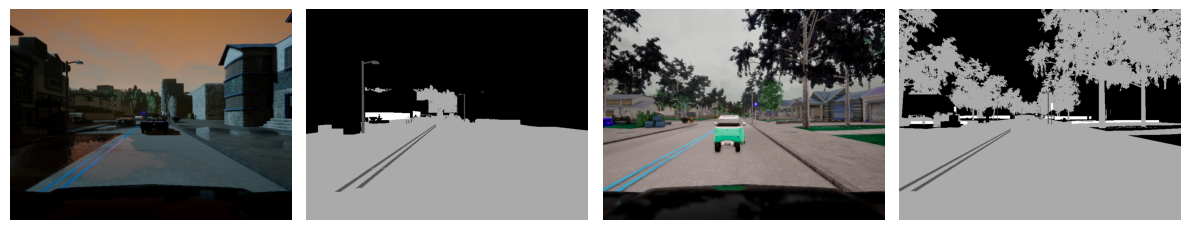

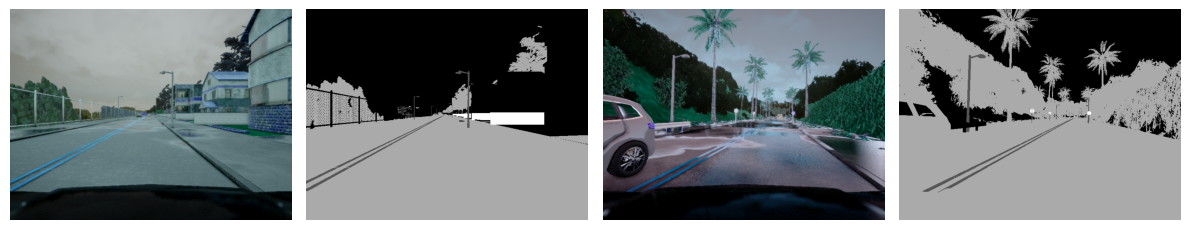

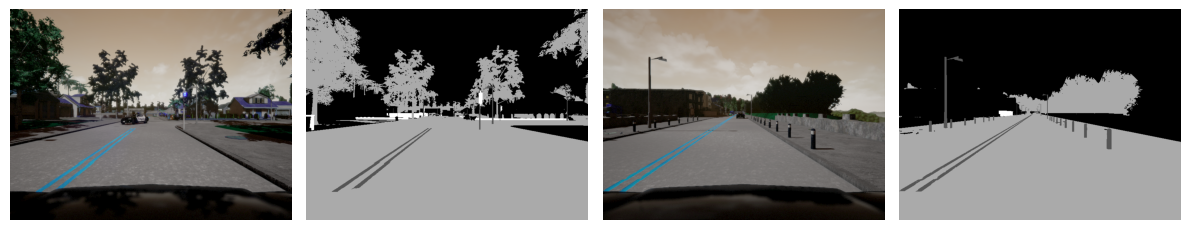

In [4]:
data_folders = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']

for i in range(len(data_folders)):
    display_images(data_folders[i], 2, shuffle=True)

# Data Preprocessing

In [5]:
image_paths = []
mask_paths = []

for folder in data_folders:
    images_each_folder = glob.glob(f'./road_dataset/{folder}/{folder}/CameraRGB/*.png')
    masks_each_folder = glob.glob(f'./road_dataset/{folder}/{folder}/CameraSeg/*.png')
    image_paths.extend(images_each_folder)
    mask_paths.extend(masks_each_folder)

len(image_paths), len(mask_paths)

(5000, 5000)

In [6]:
image_paths_TENSOR = tf.constant(image_paths)
mask_paths_TENSOR = tf.constant(mask_paths)

path_dataset = tf.data.Dataset.from_tensor_slices((image_paths_TENSOR, mask_paths_TENSOR))
path_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [7]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)  # tensor of raw byte content, cannot read
    image = tf.image.decode_png(image, channels=3)  # decode to the tensor of shape (height, width, channels)
    image = tf.image.convert_image_dtype(image, tf.float32) # normalize from 0 to 1

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # reduce from 3 channels to 1
    # no normalization on a mask because it contains each class for each pixel 
    return image, mask

In [8]:
def resize_image(image, mask):
    resized_image = tf.image.resize(image, (96, 128), method='nearest')
    resized_mask = tf.image.resize(mask, (96, 128), method='nearest')  # pick this method to preserve classes
    return resized_image, resized_mask

In [9]:
image_dataset = path_dataset.map(process_path)
image_dataset = image_dataset.map(resize_image)
image_dataset

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>

In [19]:
classes = set()

for _, mask_tensor in image_dataset.batch(5000):
    mask_array = mask_tensor.numpy()
    unique_values = np.unique(mask_array.flatten())
    classes.update(unique_values)

classes = sorted(classes)
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

##### Model Details

<div style="text-align: center;">
    <img src="images/unet.png" style="width:800px;height:500px;" alt="Identity Block Diagram">
</div>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

##### Important Note: 
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

### Encoder

In [11]:
def downsampling_block(input, n_filters, dropout_prob=0, max_pooling=True):
    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same', 
        activation='relu', 
        kernel_initializer='he_normal')(input)
    
    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same', 
        activation='relu', 
        kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = keras.layers.Dropout(dropout_prob)(conv)
        
    residual = conv
    
    if max_pooling:
        pool = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv)
        return pool, residual

    return conv, residual

### Decoder

In [12]:
def upsampling_block(input, residual, n_filters):
    up_conv = keras.layers.Conv2DTranspose(n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(input)
    concat = keras.layers.Concatenate(axis=3)([up_conv, residual])
    
    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same', 
        activation='relu',
        kernel_initializer='he_normal')(concat)

    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same', 
        activation='relu',
        kernel_initializer='he_normal')(conv)
    
    return conv

### Now, Build a Complete Model

In [13]:
def UNet(input_shape=(96, 128, 3), n_filters=32, n_classes=23):
    input = keras.layers.Input(shape=input_shape)  # input_shape(H, W, 3)
    
    pool_1, res_1 = downsampling_block(input, n_filters)  # (H/2, W/2, C), (H, W, C)
    pool_2, res_2 = downsampling_block(pool_1, n_filters*2)  # (H/4, W/4, 2C), (H/2, W/2, 2C)
    pool_3, res_3 = downsampling_block(pool_2, n_filters*4)  # (H/8, W/8, 4C), (H/4, W/4, 4C)
    pool_4, res_4 = downsampling_block(pool_3, n_filters*8, dropout_prob=0.3)  # (H/16, W/16, 8C), (H/8, W/8, 8C)
    
    conv_5, _ = downsampling_block(pool_4, n_filters*16, dropout_prob=0.3, max_pooling=False)  # (H/16, W/16, 16C)
    
    conv_6 = upsampling_block(conv_5, res_4, n_filters*8)  # (H/8, W/8, 8C)
    conv_7 = upsampling_block(conv_6, res_3, n_filters*4)  # (H/4, W/4, 4C)
    conv_8 = upsampling_block(conv_7, res_2, n_filters*2)  # (H/2, W/2, 2C)
    conv_9 = upsampling_block(conv_8, res_1, n_filters)  # (H, W, C)
    
    conv_10 = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same',
        activation='relu',
        kernel_initializer='he_normal')(conv_9)  # (H, W, C)
        
    output = keras.layers.Conv2D(n_classes, kernel_size=(1,1), strides=(1,1), padding='same')(conv_10)  # (H, W, n_classes)
    
    model = keras.models.Model(inputs=input, outputs=output)
    return model

In [14]:
unet = UNet()
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 128, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 96, 128, 32)       │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 96, 128, 32)       │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 48, 64, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 48, 64, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 48, 64, 64)        │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 24, 32, 64)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 24, 32, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 24, 32, 128)       │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 12, 16, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 12, 16, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 12, 16, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 12, 16, 256)       │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 6, 8, 256)         │               0 │ dropout[0][0]              │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 6, 8, 512)         │       1,180,160 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 6, 8, 512)         │       2,359,80

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [15]:
unet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
BUFFER_SIZE = 500
BATCH_SIZE = 64

batch_dataset = image_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
n_samples = batch_dataset.reduce(0, lambda x, _: x+1).numpy()
n_samples  # 79 samples each batch

79

In TensorFlow's dataset API, `cache()` and `shuffle(BUFFER_SIZE)` are commonly used methods to optimize dataset performance and ensure data randomness. Here’s a brief overview of each:

1. `cache()`: 
   - **Purpose**: Caches the dataset in memory after the first epoch to speed up subsequent epochs.
   - **Effect**: Once the dataset is cached, it is loaded and processed only once. This reduces the overhead of data loading and preprocessing for each epoch, leading to faster training times.
   - **Usage**: It is especially useful when the dataset fits into memory and you want to avoid redundant data loading operations.
---
2. `shuffle()`:
   - **Purpose**: Randomly shuffles the dataset to ensure that the training data is presented in a randomized order.
   - **Effect**: The dataset is shuffled by loading `BUFFER_SIZE` elements into a buffer and randomly reordering them. This approach helps to maintain randomness without requiring the entire dataset to be held in memory.
   - **Parameter**: `BUFFER_SIZE` specifies the number of elements to be loaded into the buffer at a time. A larger buffer size results in better shuffling but requires more memory.

In [17]:
train_dataset = batch_dataset.take(int(0.8*n_samples))
val_dataset = batch_dataset.skip(int(0.8*n_samples))

train_dataset, val_dataset

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 192, 256, 1), dtype=tf.uint8, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 192, 256, 1), dtype=tf.uint8, name=None))>)

In [18]:
history = unet.fit(train_dataset, epochs=40, validation_data=val_dataset)